# Q variation
In this notebook we study the variance of the Q values for a given state in order to see if the choice of the best action is founded or if it is random.

In [49]:
import sys
import os

import pickle
from fqi.dataset_preprocessing import *
from matplotlib import pyplot as plt
from fqi.result_plot import *
pd.options.display.max_columns = None
from numpy import matlib

In [50]:
%matplotlib inline

In [51]:
data_path = os.path.join(file_path, '..', '..', '..', '..', '..', '..', '..', 'data',
                                             'ferrari', 'driver', 'datasets', 'same_setup', 'csv')
track_file_name = 'ds_with_last_budapest_10'
rt_file_name = 'no_proc_rt_same_setup_budapest'

In [59]:
dataset = prepare_dataset(os.path.join(data_path, track_file_name + '.csv'),
                              os.path.join(data_path, rt_file_name + '.csv'),
                              reward_function='progress', delta_t=0)

In [60]:
algorithm_name = 'alg_double_fqi_last_new_state_v4.pkl'#'alg_double_fqi_last_nofilt.pkl'
algorithm_path = '../fqi_experiments/same_setup/'
with open(algorithm_path + algorithm_name, 'rb') as alg:
    algorithm = pickle.load(alg)

In [61]:
track_in_file_name = 'budapest_InnerTrackEdge.csv'
track_out_file_name = 'budapest_OuterTrackEdge.csv'
track_in = pd.read_csv(os.path.join(data_path, track_in_file_name))
track_out = pd.read_csv(os.path.join(data_path, track_out_file_name))

In [62]:
eval_file_name = 'eval_alg_double_fqi_last_new_state_v4.pkl'#'eval_alg_double_fqi_last_nofilt.pkl'
with open(os.path.join(fqi_exp_path, eval_file_name), 'rb') as e:
    evaluation = pickle.load(e)

simulation = pd.read_csv(os.path.join(data_path, track_file_name + '.csv'),
                         dtype={'isReference': bool})

In [63]:
ad_file_name = 'AD_alg_double_fqi_last_new_state_v4.pkl'#'AD_alg_double_fqi_last_nofilt.pkl'
ad_path = '../fqi_experiments/same_setup/'
with open(ad_path + ad_file_name, 'rb') as ad:
    action_dispatcher = pickle.load(ad)

In [57]:
dataset = prepare_dataset(os.path.join(data_path, track_file_name + '.csv'),
                              os.path.join(data_path, rt_file_name + '.csv'),
                              reward_function='progress', delta_t=0)

# Lap 1

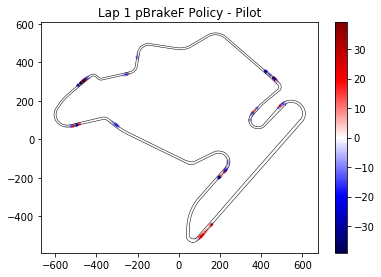

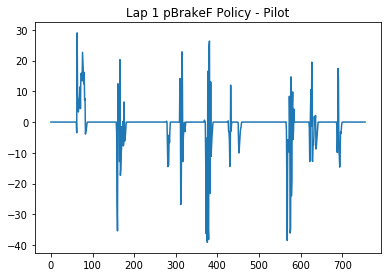

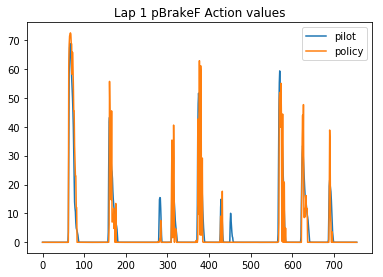

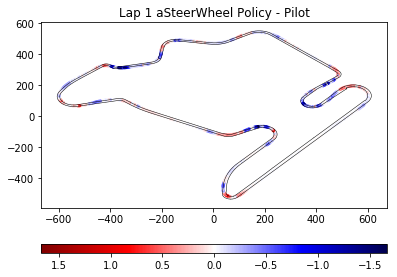

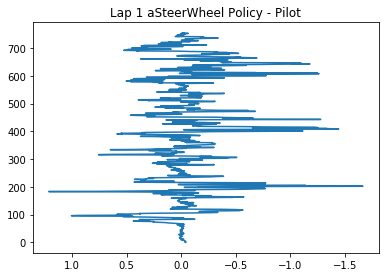

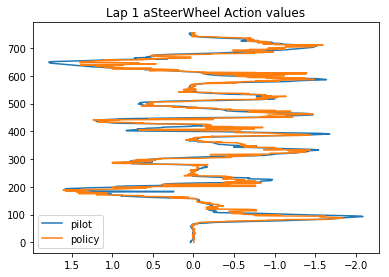

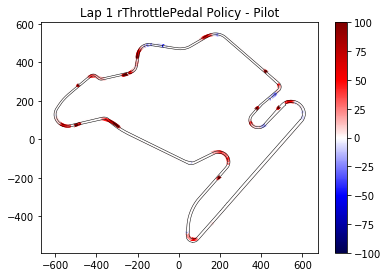

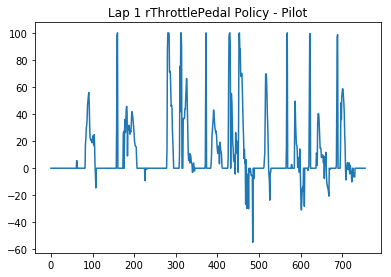

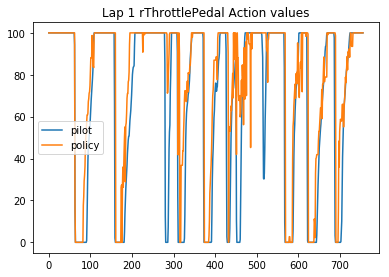

In [64]:
lap = 1

for i in range(len(action_cols)):
    f, ax = plot_track(track_in, track_out)
    plot_action_delta(lap, i, simulation, evaluation, f, ax)

In [12]:
action_cols

['pBrakeF', 'aSteerWheel', 'rThrottlePedal']

In [13]:
evaluation[1][2][17:19]

array([[6.99767377e-03, 3.92578170e-03, 1.00000000e+02],
       [7.07619172e-03, 5.08500775e-03, 1.00000000e+02]])

Text(0.5,1,'Lap 1 rThrottlePedal value')

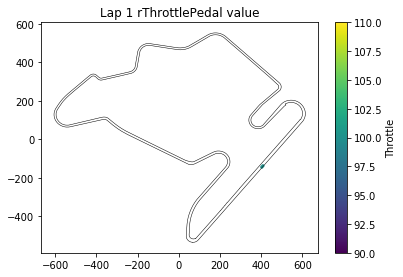

In [14]:
action_pos = 2
interval = range(17,19)
lap_mask = simulation['NLap'] == lap
    
policyA = evaluation[lap][2][:, action_pos]
pilotA = np.array(simulation[lap_mask][action_cols[action_pos]])

value = policyA - pilotA

minv = min(value)
maxv = max(value)
bound = max((abs(minv), abs(maxv)))
f, ax = plot_track(track_in, track_out)
#s = ax.scatter(simulation['xCarWorld'][lap_mask].values[interval],
#               simulation['yCarWorld'][lap_mask].values[interval],
#               s=5, c=value[interval], cmap='seismic', vmin=-bound, vmax=bound)
s = ax.scatter(simulation['xCarWorld'][lap_mask].values[interval],
               simulation['yCarWorld'][lap_mask].values[interval],
               s=5, c=policyA[interval])
cbar = f.colorbar(s, ax=ax)
cbar.set_label('Throttle')
ax.set_title('Lap ' + str(lap) + ' ' + action_cols[action_pos] + ' value')

In [15]:
evaluation[lap][2][interval, action_pos]

array([100., 100.])

In [16]:
evaluation[lap][1][interval]

array([4.42859314, 4.41674368])

For the 31th state of the first lap the policy stops to accelerate and starts to brake even if this action is wrong. For this state we study the Q values of the actions in the action set to see how much this wrong action has a greater Q with respect to the others.

In [17]:
lap_mask = dataset.NLap == 1
s = dataset[state_cols][lap_mask].values[interval]

In [18]:
ids = (action_dispatcher.kdtree.query_radius(s[:, action_dispatcher.state_mask],
                                                r=action_dispatcher.radius))

a = list(map(lambda x: list(map(lambda i: action_dispatcher.actions[i], x)), ids))

print('N actions list {}'.format(len(a)))

actions_dict= {}
for i in range(len(s)):            
    actions_dict[tuple(s[i, :])] = a[i]

N actions list 2


In [19]:
n_actions = len(a)
n_states = s.shape[0]
state_dim = len(state_cols)
action_dim = len(action_cols)

n_actions_per_state = list(map(lambda x: len(x), map(lambda s: actions_dict[tuple(s)], s)))
tot_n_actions = sum(n_actions_per_state)
n_states = s.shape[0]
sa = np.empty((tot_n_actions, len(state_cols) + len(action_cols)))

end = 0
for i in range(n_states):
    # set interval variables
    start = end
    end = end + n_actions_per_state[i]
    
    # set state prime
    i_s_prime = s[i, :]
    n_actions = n_actions_per_state[i]

    # populate the matrix with the ith state prime
    sa[start:end, 0:len(state_cols)] = matlib.repmat(i_s_prime, n_actions, 1)

    # populate the matrix with the actions of the action set of ith state prime
    sa[start:end, len(state_cols):] =\
        np.array(actions_dict[tuple(i_s_prime)]).reshape((n_actions, len(action_cols)))

In [20]:
sa.shape

(308, 21)

In [21]:
Q = algorithm._policy.Q

vals = Q.values(sa)

In [22]:
state_i_actions = actions_dict[tuple(s[0,:])]
vals_i = vals[:len(state_i_actions)]
state_n_actions = actions_dict[tuple(s[1,:])]
vals_n = vals[len(state_n_actions):]

In [23]:
len(state_i_actions)

154

In [24]:
len(state_n_actions)

154

(array([ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., 22., 69., 61.]),
 array([3.8556381 , 3.87473661, 3.89383511, 3.91293361, 3.93203211,
        3.95113061, 3.97022911, 3.98932761, 4.00842611, 4.02752461,
        4.04662312, 4.06572162, 4.08482012, 4.10391862, 4.12301712,
        4.14211562, 4.16121412, 4.18031262, 4.19941112, 4.21850962,
        4.23760813, 4.25670663, 4.27580513, 4.29490363, 4.31400213,
        4.33310063, 4.35219913, 4.37129763, 4.39039613, 4.40949464,
        4.42859314]),
 <a list of 30 Patch objects>)

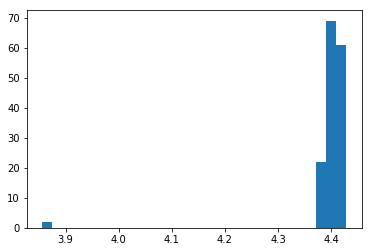

In [25]:
plt.hist(vals_i, 30)

Text(0.5,0,'Throttle')

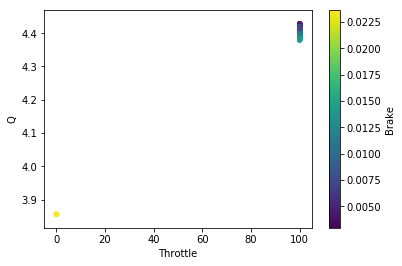

In [26]:
throttle_state_i = [a[2] for a in state_i_actions]
brake_state_i = [a[0] for a in state_i_actions]
s = plt.scatter(throttle_state_i, vals_i, c=brake_state_i, s=20)
cbar = plt.colorbar(s)
cbar.set_label('Brake')
plt.ylabel('Q')
plt.xlabel('Throttle')

Text(0.5,0,'Brake')

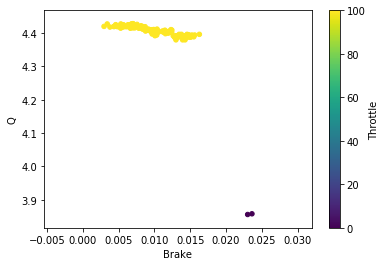

In [27]:
throttle_state_i = [a[2] for a in state_i_actions]
brake_state_i = [a[0] for a in state_i_actions]
s = plt.scatter(brake_state_i, vals_i, c=throttle_state_i, s=20)
cbar = plt.colorbar(s)
cbar.set_label('Throttle')
plt.ylabel('Q')
plt.xlabel('Brake')

(array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., 71., 81.]),
 array([3.87198124, 3.89013999, 3.90829874, 3.92645749, 3.94461623,
        3.96277498, 3.98093373, 3.99909248, 4.01725123, 4.03540997,
        4.05356872, 4.07172747, 4.08988622, 4.10804497, 4.12620371,
        4.14436246, 4.16252121, 4.18067996, 4.19883871, 4.21699745,
        4.2351562 , 4.25331495, 4.2714737 , 4.28963245, 4.30779119,
        4.32594994, 4.34410869, 4.36226744, 4.38042619, 4.39858493,
        4.41674368]),
 <a list of 30 Patch objects>)

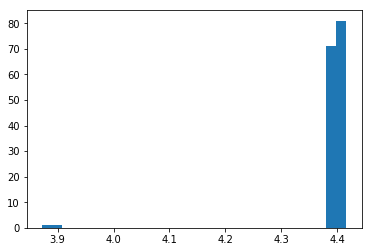

In [28]:
plt.hist(vals_n, 30)

Text(0.5,0,'Throttle')

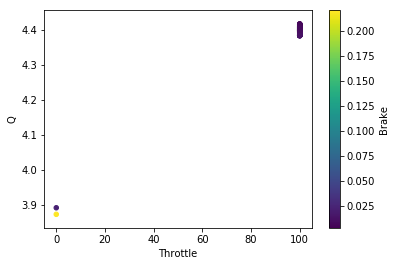

In [29]:
throttle_state_n = [a[2] for a in state_n_actions]
brake_state_n = [a[0] for a in state_n_actions]
s = plt.scatter(throttle_state_n, vals_n, c=brake_state_n, s=20)
cbar = plt.colorbar(s)
cbar.set_label('Brake')
plt.ylabel('Q')
plt.xlabel('Throttle')


# Lap 6

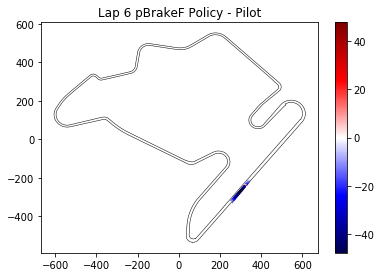

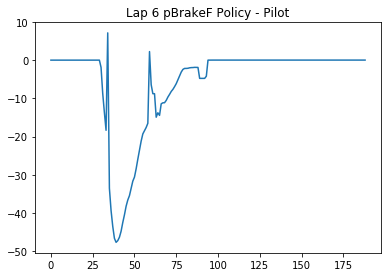

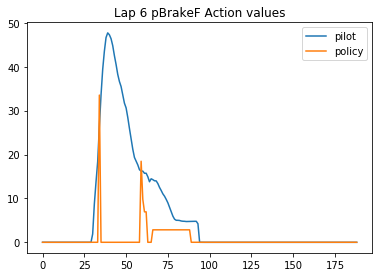

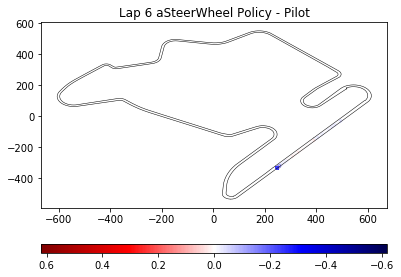

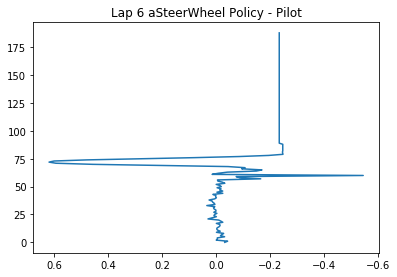

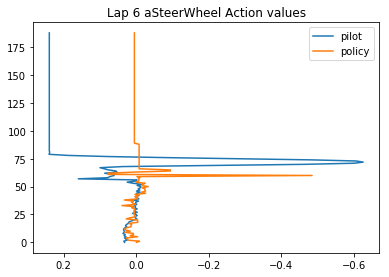

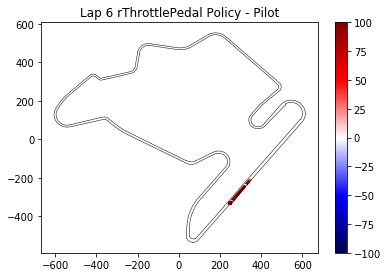

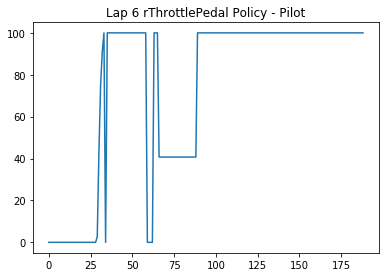

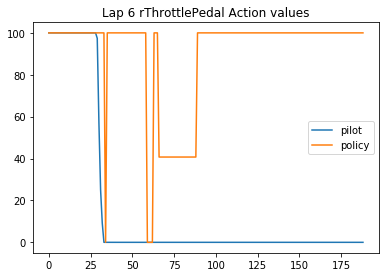

In [30]:
lap = 6
lap_mask= simulation.NLap == lap
for i in range(len(action_cols)):
    f, ax = plot_track(track_in, track_out)
    plot_action_delta(lap, i, simulation, evaluation, f, ax)

In [31]:
simulation[lap_mask].rThrottlePedal.values[28:35]

array([1.00000000e+02, 9.74082184e+01, 5.70992813e+01, 2.50826569e+01,
       9.16305637e+00, 7.90994056e-03, 0.00000000e+00])

In [32]:
evaluation[lap][0][28:35]

array([  3.95461027,   3.85325958,   2.69926647,  -6.56723513,
       -16.78299869, -27.65226668, -34.57434878])

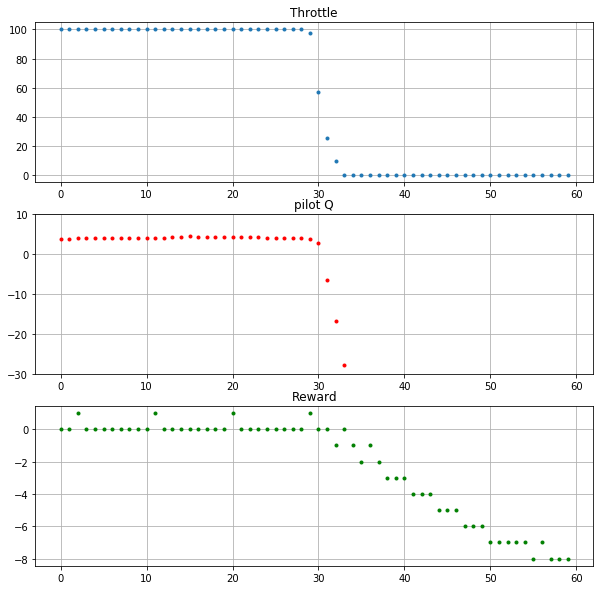

In [33]:
f,axs = plt.subplots(3,1, figsize=(10,10))
int_val = range(0, 60)
axs[0].plot(simulation[simulation.NLap == lap].rThrottlePedal.values[int_val], '.')
axs[0].set_title('Throttle')
axs[0].grid()
axs[1].plot(evaluation[lap][0][int_val],  'r.')
axs[1].set_title('pilot Q')
axs[1].set_ylim((-30, 10))
axs[1].grid()
axs[2].plot(dataset[dataset.NLap == lap].r.values[int_val], 'g.')
axs[2].set_title('Reward')
axs[2].grid()

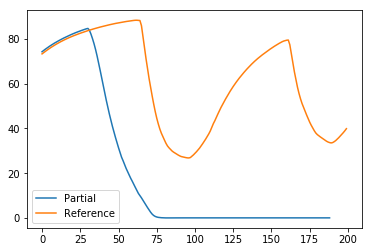

In [34]:
plt.plot(simulation['actualSpeedModule'][simulation.NLap == 6].values)
plt.plot(simulation['actualSpeedModule'][simulation.NLap == 46].values[:200])
plt.legend(('Partial', 'Reference'))

Text(0.5,1,'Lap 6 rThrottlePedal value')

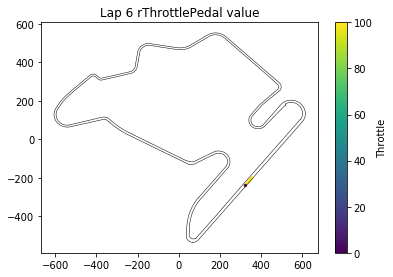

In [35]:
action_pos = 2
interval = range(28,35)
lap_mask = simulation['NLap'] == lap
    
policyA = evaluation[lap][2][:, action_pos]
pilotA = np.array(simulation[lap_mask][action_cols[action_pos]])

value = policyA - pilotA

minv = min(value)
maxv = max(value)
bound = max((abs(minv), abs(maxv)))
f, ax = plot_track(track_in, track_out)
#s = ax.scatter(simulation['xCarWorld'][lap_mask].values[interval],
#               simulation['yCarWorld'][lap_mask].values[interval],
#               s=5, c=value[interval], cmap='seismic', vmin=-bound, vmax=bound)
s = ax.scatter(simulation['xCarWorld'][lap_mask].values[interval],
               simulation['yCarWorld'][lap_mask].values[interval],
               s=5, c=policyA[interval])
cbar = f.colorbar(s, ax=ax)
cbar.set_label('Throttle')
ax.set_title('Lap ' + str(lap) + ' ' + action_cols[action_pos] + ' value')

In [36]:
evaluation[lap][2][interval, action_pos]

array([100., 100., 100., 100., 100., 100.,   0.])

In [37]:
lap_mask = dataset.NLap == lap
s = dataset[state_cols][lap_mask].values[interval]

In [38]:
ids = (action_dispatcher.kdtree.query_radius(s[:, action_dispatcher.state_mask],
                                                r=action_dispatcher.radius))

a = list(map(lambda x: list(map(lambda i: action_dispatcher.actions[i], x)), ids))

print('N actions list {}'.format(len(a)))

actions_dict= {}
for i in range(len(s)):            
    actions_dict[tuple(s[i, :])] = a[i]

N actions list 7


In [39]:
n_actions = len(a)
n_states = s.shape[0]
state_dim = len(state_cols)
action_dim = len(action_cols)

n_actions_per_state = list(map(lambda x: len(x), map(lambda s: actions_dict[tuple(s)], s)))
tot_n_actions = sum(n_actions_per_state)
n_states = s.shape[0]
sa = np.empty((tot_n_actions, len(state_cols) + len(action_cols)))

end = 0
for i in range(n_states):
    # set interval variables
    start = end
    end = end + n_actions_per_state[i]
    
    # set state prime
    i_s_prime = s[i, :]
    n_actions = n_actions_per_state[i]

    # populate the matrix with the ith state prime
    sa[start:end, 0:len(state_cols)] = matlib.repmat(i_s_prime, n_actions, 1)

    # populate the matrix with the actions of the action set of ith state prime
    sa[start:end, len(state_cols):] =\
        np.array(actions_dict[tuple(i_s_prime)]).reshape((n_actions, len(action_cols)))

In [40]:
n_actions_per_state

[138, 139, 139, 141, 143, 147, 151]

In [41]:
Q = algorithm._policy.Q

vals = Q.values(sa)

In [42]:
state_i_actions = actions_dict[tuple(s[0,:])]
vals_i = vals[:len(state_i_actions)]
state_n_actions = actions_dict[tuple(s[1,:])]
vals_n = vals[len(state_i_actions):len(state_i_actions)+n_actions_per_state[1]]

In [43]:
len(vals_n)

139

(array([ 4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0., 42., 91.]),
 array([3.2622063 , 3.28528643, 3.30836656, 3.33144669, 3.35452683,
        3.37760696, 3.40068709, 3.42376722, 3.44684736, 3.46992749,
        3.49300762, 3.51608775, 3.53916789, 3.56224802, 3.58532815,
        3.60840828, 3.63148842, 3.65456855, 3.67764868, 3.70072881,
        3.72380895, 3.74688908, 3.76996921, 3.79304934, 3.81612948,
        3.83920961, 3.86228974, 3.88536987, 3.90845001, 3.93153014,
        3.95461027]),
 <a list of 30 Patch objects>)

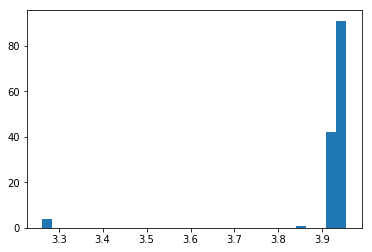

In [44]:
plt.hist(vals_i, 30)

Text(0.5,0,'Throttle')

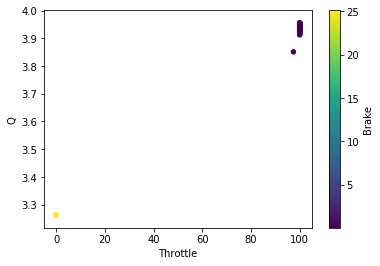

In [45]:
throttle_state_i = [a[2] for a in state_i_actions]
brake_state_i = [a[0] for a in state_i_actions]
s = plt.scatter(throttle_state_i, vals_i, c=brake_state_i, s=20)
cbar = plt.colorbar(s)
cbar.set_label('Brake')
plt.ylabel('Q')
plt.xlabel('Throttle')

Text(0.5,0,'Brake')

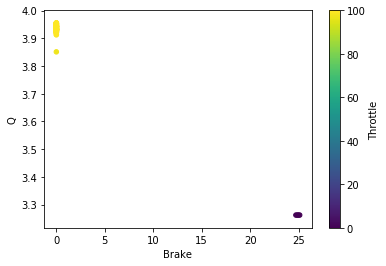

In [46]:
throttle_state_i = [a[2] for a in state_i_actions]
brake_state_i = [a[0] for a in state_i_actions]
s = plt.scatter(brake_state_i, vals_i, c=throttle_state_i, s=20)
cbar = plt.colorbar(s)
cbar.set_label('Throttle')
plt.ylabel('Q')
plt.xlabel('Brake')

(array([ 4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  1., 59., 73.]),
 array([3.26259797, 3.28560103, 3.30860409, 3.33160714, 3.3546102 ,
        3.37761326, 3.40061632, 3.42361938, 3.44662243, 3.46962549,
        3.49262855, 3.51563161, 3.53863466, 3.56163772, 3.58464078,
        3.60764384, 3.6306469 , 3.65364995, 3.67665301, 3.69965607,
        3.72265913, 3.74566219, 3.76866524, 3.7916683 , 3.81467136,
        3.83767442, 3.86067747, 3.88368053, 3.90668359, 3.92968665,
        3.95268971]),
 <a list of 30 Patch objects>)

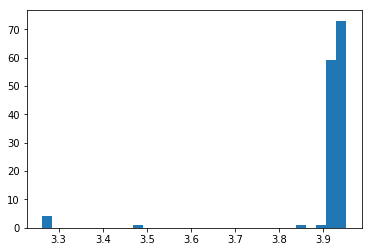

In [47]:
plt.hist(vals_n, 30)

Text(0.5,0,'Throttle')

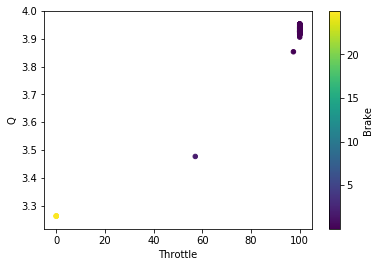

In [48]:
throttle_state_n = [a[2] for a in state_n_actions]
brake_state_n = [a[0] for a in state_n_actions]
s = plt.scatter(throttle_state_n, vals_n, c=brake_state_n, s=20)
cbar = plt.colorbar(s)
cbar.set_label('Brake')
plt.ylabel('Q')
plt.xlabel('Throttle')
